# **EE6132: Panoramic Stitching**



# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_features

2. match_keypoints

3. find_homography and transform_ransac 

4. panoramic_stitching

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
%matplotlib inline
import cv2
import random
import sys
import numpy as np
import imutils
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

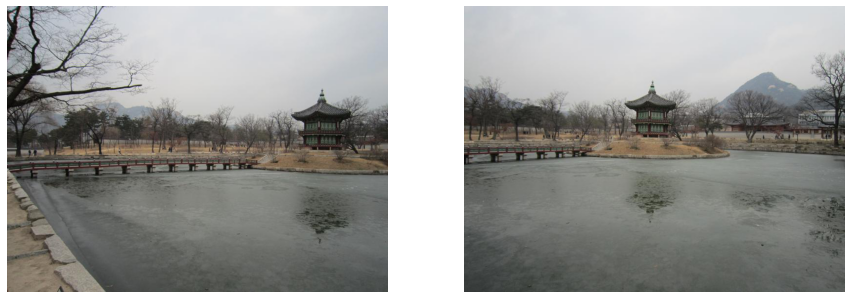

In [2]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')


def plot_imgs(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 20))
    for a in ax:
        a.set_axis_off()
    ax[0].imshow(img1)
    ax[1].imshow(img2)


plot_imgs(img1, img2)

# Compute SURF/ SIFT/ ORB Features and Match Keypoints

In [3]:
def get_features(img):
    '''
      Compute SURF/SIFT/ORB features using cv2 library functions. Use default parameters when computing the keypoints.
      Input:
        img: cv2 image
      Returns:
        keypoints: a list of cv2 keypoints
        descriptors: a list of feature descriptors
    '''
    orb = cv2.ORB_create()
    (keypoints, descriptors) = orb.detectAndCompute(img, None)
    return keypoints, descriptors


def match_keypoints(desc_1, desc_2, ratio=0.75):
    '''
      You may use cv2 library functions.
      Input:
        desc_1, desc_2: list of feature descriptors
      Return:
        matches: list of feature matches
    '''
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Match descriptors.
    matches = bf.match(desc_1,desc_2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    
    return matches

keypoints for img1 and img2


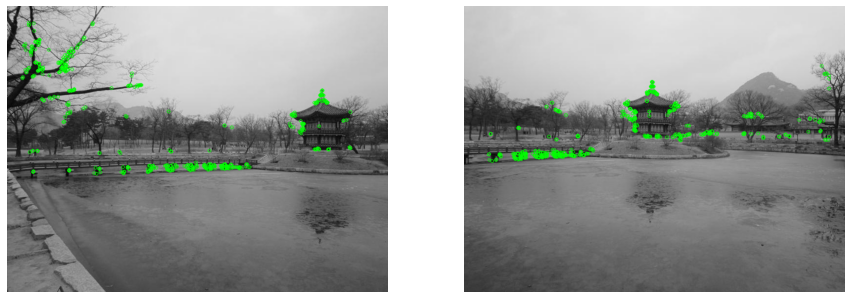

In [4]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

kp_1, desc_1 = get_features(img1)
kp_2, desc_2 = get_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

feature matches


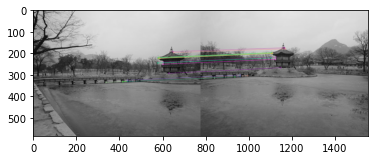

In [5]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("feature matches")
plt.imshow(match_plot)
plt.show()

# Compute Homography Matrix using RANSAC

In [6]:
def find_homography(pts_1, pts_2):
    '''
      Implement Direct Linear Transform to find a homography that estimates the transformation mapping from pts_1 to pts_2.
      e.g. If x is in pts_1 and y is in pts_2, then y = H * x
      Input:
        pts_1, pts_1: (N, 2) matrix
      Return:
        H: the resultant homography matrix (3 x 3)
    '''
    if pts_1.shape != pts_2.shape:
        raise RuntimeError('number of points do not match')

    n_correspondences = pts_1.shape[0]
    A = np.zeros((2*n_correspondences, 9))
    for i in range(n_correspondences):
        A[2*i, :] = [-pts_1[i][0], -pts_1[i][1], -1, 0, 0, 0,
                     pts_1[i][0]*pts_2[i][0], pts_1[i][1]*pts_2[i][0], pts_2[i][0]]
        A[2*i + 1, :] = [0, 0, 0, -pts_1[i][0], -pts_1[i][1], -1,
                         pts_1[i][0]*pts_2[i][1], pts_1[i][1]*pts_2[i][1], pts_2[i][1]]

    U, S, Vh = np.linalg.svd(A)
    H = Vh[8].reshape(3, 3)
    return (H / H[-1, -1])

In [7]:
def transform_ransac(pts_1, pts_2):
    '''
      Implement RANSAC to estimate homography matrix.
      Input:
        pts_1, pts_1: (N, 2) matrices
      Return:
        best_model: homography matrix with most inliers
    '''
    ransac_iters = 50
    threshold_distance = 0.5
    threshold_inliers = 0
    src_inliers = None
    dst_inliers = None
    best_model = None

    for it in range(ransac_iters):
        np.random.seed(69)
        #Indexing 4 points from the sample of 174 matching points.
        indexes = random.sample(range(pts_1.shape[0]), 4)
        #Finding the 4 matching points
        fp = pts_1[indexes]
        tp = pts_2[indexes]
        #Finding exact homography using find_homography function
        homography = find_homography(fp, tp)

        # Converting all points to Homogeneous coordinate system
        src_pts = np.hstack(
            (pts_1, np.ones((pts_1.shape[0], 1), dtype=pts_1.dtype))).T
        dst_pts = np.hstack(
            (pts_2, np.ones((pts_2.shape[0], 1), dtype=pts_2.dtype))).T
        
        #Finding projected points
        projected_pts = np.dot(homography, src_pts)
        #SSD error
        error = np.sqrt(
            np.sum(np.square(dst_pts - (projected_pts/projected_pts[-1])), axis=0))

        if np.count_nonzero(error < threshold_distance) > threshold_inliers:
            print(it)
            src_inliers = src_pts[:, np.argwhere(
                error < threshold_distance).flatten()][:-1].T
            dst_inliers = dst_pts[:, np.argwhere(
                error < threshold_distance).flatten()][:-1].T
            best_model = homography
            num_inliers = np.count_nonzero(error < threshold_distance)
            threshold_inliers = num_inliers

    return best_model

# Panoramic Stitching

In [11]:
def panoramic_stitching(img1, img2):
    '''
      Generate a panoramic image using the obtained homography matrix.
      Input: 
        img1, img2: cv2 images
      Return:
        final_img: cv2 image of panorama
    '''
    kp_1, desc_1 = get_features(img1)
    kp_2, desc_2 = get_features(img2)
    kpsA = np.float32([kp.pt for kp in kp_1])
    kpsB = np.float32([kp.pt for kp in kp_2])
    matches = match_keypoints(desc_1, desc_2)
    ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
    H = transform_ransac(ptsA, ptsB)

    leftImage  = np.asarray(img1)
    each = np.asarray(img2)
    txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
    txyz = txyz/txyz[-1]
    dsize = (int(txyz[0])+leftImage.shape[1],
             int(txyz[1])+leftImage.shape[0])
    warpedImage = cv2.warpPerspective(each, H, dsize)
    i1y, i1x = leftImage.shape[:2]
    i2y, i2x = warpedImage.shape[:2]

    black_l = np.where(leftImage == np.array([0, 0, 0]))
    black_wi = np.where(warpedImage == np.array([0, 0, 0]))

    for i in range(0, i1x):
        for j in range(0, i1y):
            try:
                if(np.array_equal(leftImage[j, i], np.array([0, 0, 0])) and np.array_equal(warpedImage[j, i], np.array([0, 0, 0]))):
                    # print "BLACK"
                    # instead of just putting it with black,
                    # take average of all nearby values and avg it.
                    warpedImage[j, i] = [0, 0, 0]
                else:
                    if(np.array_equal(warpedImage[j, i], [0, 0, 0])):
                        # print "PIXEL"
                        warpedImage[j, i] = leftImage[j, i]
                    else:
                        if not np.array_equal(leftImage[j, i], [0, 0, 0]):
                            bw, gw, rw = warpedImage[j, i]
                            bl, gl, rl = leftImage[j, i]
                            # b = (bl+bw)/2
                            # g = (gl+gw)/2
                            # r = (rl+rw)/2
                            warpedImage[j, i] = [bl, gl, rl]
            except:
                pass
    panorama = warpedImage
    return panorama

0
4
7
26
34


True

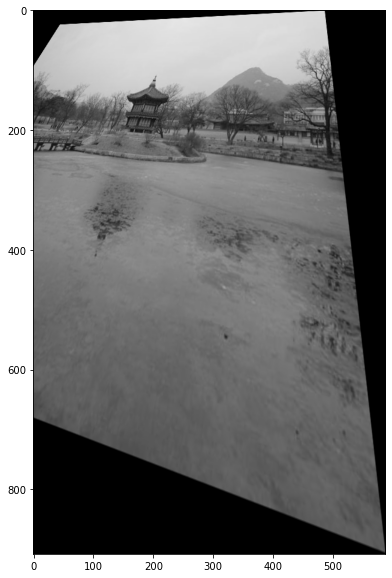

In [12]:
result = panoramic_stitching(img1, img2)

# transform the panorama image to grayscale and threshold it 
# gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
gray = result
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]
result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)
cv2.imwrite('./pano.jpg', result)

### Using the inbuilt cv2 methods to compute homography and stich the 2 panoramic images

In [16]:
kp_1, desc_1 = get_features(img1)
kp_2, desc_2 = get_features(img2)
kpsA = np.float32([kp.pt for kp in kp_1])
kpsB = np.float32([kp.pt for kp in kp_2])
matches = match_keypoints(desc_1, desc_2)
ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

H, mask = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)
width = img1.shape[1] + img2.shape[1]
height = img1.shape[0]
result = cv2.warpPerspective(img2, H, (width, height))
result[0:img1.shape[0], 0:img1.shape[1]] = img1

result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
# show the cropped image
def trim(frame):
    # crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    # crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    # crop top
    if not np.sum(frame[:, 0]):
        return trim(frame[:, 1:])
    # crop top
    if not np.sum(frame[:, -1]):
        return trim(frame[:, :-2])
    return frame

plt.figure(figsize=(20,10))
plt.imshow(trim(result))
cv2.imwrite('./pano2.jpg', trim(result))

ValueError: too many values to unpack (expected 2)

We can see that stiching algorithm output provided by our own functions for finding Homography through RANSAC algorithm and the one found using the built in CV2 built-in methods gave similar output. Both of the stiching methods failed to provide perfct panorama for some reasons. I suspect the feature matching from ORB failed to provide all the necessary features and hence both of the approach failed. We got 174 matching features through ORB during feature matching. The homography matrix computed through ``transform_ransac`` seems to be correct. The randomised approach gives us different answers for different iterations despite defining random state in the beginning. But it is fairly robust.
